## Sulphur precursor evaporation
The code is structured as follows. Defining all global variables so they can be used in different parts of this code as well as across codes for convenience. The code asks for flow rate (in sccm) and final time (in seconds). We usually run for 100 sccm and for 1 hr= 3600 s, you can also try for 1 sccm and 3600s, or 100 sccm and 7200 seconds.
Changing the flow rate will show the precursor cloud being more symmetric or shifting forward showing increased effect of convection. Rest of the variables are mentioned in the script itself. Vapor pressure is found using  expressions given in the ACS Nano paper (https://pubs.acs.org/doi/abs/10.1021/acsnano.5b07916). After this, we define a time and x mesh as desired and call the solver's solution (sol) and plot it. Here, we give the evaporation function and temperature profile of tube and how the density and velocity depends on temperature. Basically our coefficients in DCE like D, Velocity etc are all temperature dependent so we define them here.)
We also provide the boundary and initial conditions.

In [11]:

"""
Convection–Diffusion with Evaporation Source (Python translation of MATLAB PDEPE code)

PDE:
    ∂u/∂t = ∂/∂x( D(x) ∂u/∂x ) - V * ∂u/∂x + S(x, t, u)

BC:
    u(0, t) = 0, u(L, t) = 0   (Dirichlet)

IC:
    u(x, 0) = 0

Author: Converted for Akshay Singh
Dependencies: numpy, scipy, matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp



defining the constants

In [12]:
# ------------------ Constants (mirroring your MATLAB) ------------------
R = 8.314         # J/(mol·K)
A = 0.002826      # m^2 (tube CSA)
densityN2 = 1.25  # kg/m^3 @ RT
MMN2 = 0.028      # kg/mol (N2)
MMS = 0.032       # kg/mol (Sulphur)
TS = 200.0        # °C (precursor temperature)
Tp = TS + 273.0   # K

# Evaporation constant from MATLAB comment (trial fit)
C_evap = 8e-9 * 0.5 * 5.7e7

# Domain and mesh
xl, xr = 0.0, 2.0
dx = 0.05
x = np.arange(xl, xr + dx, dx)
Nx = len(x)

# Substrate index (MATLAB u(:,19) -> x=19*0.05=0.95 m)
substrate_idx = 19

# Toggle: use Kelvin (recommended) in evaporation kinetic term
USE_KELVIN_IN_EVAP = True


Setting the temperature profile, and calculating the diffusivity and saturation vapour pressure from 10.1021/acsnano.5b07916

In [13]:

# ------------------ Temperature profile (piecewise along x) ------------------
# Segment temperatures (°C)
Tl1, Tl2, TZ1, TZ2, TZ3, Tr1, Tr2 = 25.0, 90.0, 200.0, 530.0, 750.0, 110.0, 25.0
# Breakpoints (m)
X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12 = \
    0.0, 0.11, 0.31, 0.385, 0.535, 0.61, 0.76, 0.835, 0.985, 1.06, 1.26, 2.0

def temperature_profile_degC(x):
    """Piecewise temperature profile T(x) in °C."""
    T = np.empty_like(x, dtype=float)

    # 1) Ramp Tl1 -> Tl2 over [X1, X2)
    mask = (x >= X1) & (x < X2)
    T[mask] = Tl1 + (Tl2 - Tl1) * (x[mask] - X1) / (X2 - X1)

    # 2) Ramp Tl2 -> TZ1 over [X2, X3)
    mask = (x >= X2) & (x < X3)
    T[mask] = Tl2 + (TZ1 - Tl2) * (x[mask] - X2) / (X3 - X2)

    # 3) Hold TZ1 over [X3, X4)
    mask = (x >= X3) & (x < X4)
    T[mask] = TZ1

    # 4) Hold TZ1 over [X4, X5)
    mask = (x >= X4) & (x < X5)
    T[mask] = TZ1

    # 5) Ramp TZ1 -> TZ2 over [X5, X6)
    mask = (x >= X5) & (x < X6)
    T[mask] = TZ1 + (TZ2 - TZ1) * (x[mask] - X5) / (X6 - X5)

    # 6) Hold TZ2 over [X6, X7)
    mask = (x >= X6) & (x < X7)
    T[mask] = TZ2

    # 7) Ramp TZ2 -> TZ3 over [X7, X8)
    mask = (x >= X7) & (x < X8)
    T[mask] = TZ2 + (TZ3 - TZ2) * (x[mask] - X7) / (X8 - X7)

    # 8) Hold TZ3 over [X8, X9)
    mask = (x >= X8) & (x < X9)
    T[mask] = TZ3

    # 9) Ramp TZ3 -> Tr1 over [X9, X10)
    mask = (x >= X9) & (x < X10)
    T[mask] = TZ3 + (Tr1 - TZ3) * (x[mask] - X9) / (X10 - X9)

    # 10) Ramp Tr1 -> Tr2 over [X10, X11)
    mask = (x >= X10) & (x < X11)
    T[mask] = Tr1 + (Tr2 - Tr1) * (x[mask] - X10) / (X11 - X10)

    # 11) Hold Tr2 over [X11, X12]
    mask = (x >= X11) & (x <= X12)
    T[mask] = Tr2

    return T


# ------------------ Diffusivity D(x) via omega11 fit ------------------
def compute_diffusivity(x):
    """
    D(x) (m^2/s) for S in N2 using the polynomial omega11 fit and empirical form
    from your MATLAB.
    """
    T_degC = temperature_profile_degC(x)
    T_K = T_degC + 273.0

    M1, M2 = 32.0, 28.0
    sigma12 = (3.418 + 4.86) / 2.0  # Å (kept as in your fit; overall scale absorbed)
    T12 = T_K / np.sqrt(124.0 * 100.0)
    z = 1.0 / T12

    # Piecewise polynomial omega11
    poly1 = (0.0002094 * T12**-9
             - 0.004099 * T12**-8
             + 0.03417  * T12**-7
             - 0.1582   * T12**-6
             + 0.4445   * T12**-5
             - 0.7762   * T12**-4
             + 0.815    * T12**-3
             - 0.4139   * T12**-2
             - 0.1604   * T12**-1
             + 1.0)

    poly2 = (-0.0059 * T12**-3
             + 0.0641 * T12**-2
             - 0.28   * T12**-1
             + 1.0063)

    cond1 = (z >= 0.0) & (z < 1.625)
    cond2 = (z >= 1.625) & (z <= 4.0)
    poly = np.where(cond1, poly1, np.where(cond2, poly2, 0.0))
    poly = np.where(poly == 0.0, 1e-12, poly)  # avoid divide-by-zero

    omega11 = 1.0 / poly

    numerator = 0.0026280 * np.sqrt((T_K**3) * ((M1 + M2) / (2.0 * M1 * M2)))
    denominator = (101325.0 / 101325.0) * (sigma12**2) * omega11
    D = (numerator / denominator) * 1e-4
    return D  # m^2/s


# ------------------ Saturation vapor pressure pS* (Pa) ------------------
def saturation_pressure_Pa(Tp):
    Adash = -7.246
    B = 0.187
    Cn = 5.2710
    Dprime = -12.128
    Tc = 1313.0  # K
    pc_kPa = 18208.0

    term = (Adash * (1 - Tp / Tc) +
            B     * (1 - Tp / Tc)**1.5 +
            Cn    * (1 - Tp / Tc)**3 +
            Dprime* (1 - Tp / Tc)**6)

    pSstar_kPa = pc_kPa * np.exp(term * (Tc / Tp))
    return pSstar_kPa * 1000.0  # Pa


Setting the source term and setting the boundary conditions

In [14]:

# ------------------ Evaporation source S(x, t, u) ------------------
def evaporation_source(x, t, u, P):
    """
    Source term (mol/(m^3·s)) localized over the boat region (0.515–0.601 m),
    active for t in [0, 3000] s. Gaussian spatial envelope centered near 0.558 m.
    """
    # Gaussian envelope (matches your MATLAB intent)
    sigma = 0.086
    A0 = C_evap * (1.0 / np.sqrt(2.0 * np.pi) * sigma) * np.exp(-((x - 0.558)**2) / (2.0 * sigma**2))

    # Active region along x
    x_mask = ((x >= 0.515) & (x <= 0.601)).astype(float)

    # Kinetic evaporation term
    if USE_KELVIN_IN_EVAP:
        denom = np.sqrt(2.0 * np.pi * MMS * R * Tp)
        kinetic = (P - R * Tp * u) / denom
    else:
        denom = np.sqrt(2.0 * np.pi * MMS * R * TS)
        kinetic = (P - R * TS * u) / denom

    # Time window: 0–3000 s
    time_active = 1.0 if (0.0 <= t <= 3000.0) else 0.0

    S = A0 * kinetic * x_mask * time_active
    return S  # shape (Nx,)


# ------------------ RHS via method of lines ------------------
def build_rhs(V, D, P):
    """
    Build RHS function f(t, u) implementing:
        ∂u/∂t = div( D ∇u ) - V ∂u/∂x + S(x, t, u)
    with Dirichlet u(0)=u(L)=0 enforced.
    """
    def rhs(t, u):
        du_dt = np.zeros_like(u)

        # Dirichlet BCs: u[0]=0, u[-1]=0 (do not evolve boundaries)
        du_dt[0] = 0.0
        du_dt[-1] = 0.0

        # Interior nodes
        # Variable-coefficient diffusion via flux-divergence
        D_iphalf = 0.5 * (D[1:-1] + D[2:])    # D_{i+1/2}
        D_imhalf = 0.5 * (D[1:-1] + D[:-2])   # D_{i-1/2}

        flux_right = D_iphalf * (u[2:] - u[1:-1]) / dx
        flux_left  = D_imhalf * (u[1:-1] - u[:-2]) / dx
        div_diff = (flux_right - flux_left) / dx

        # Convection (upwind)
        if V >= 0.0:
            u_x = (u[1:-1] - u[:-2]) / dx
        else:
            u_x = (u[2:] - u[1:-1]) / dx
        conv = -V * u_x

        # Source term (full vector)
        S = evaporation_source(x, t, u, P)

        du_dt[1:-1] = div_diff + conv + S[1:-1]
        return du_dt

    return rhs



Running the main simulation now, lets hope for the best :)

Flow rate in sccm:?  100
Time for which solution is to be computed (in s)?  3600


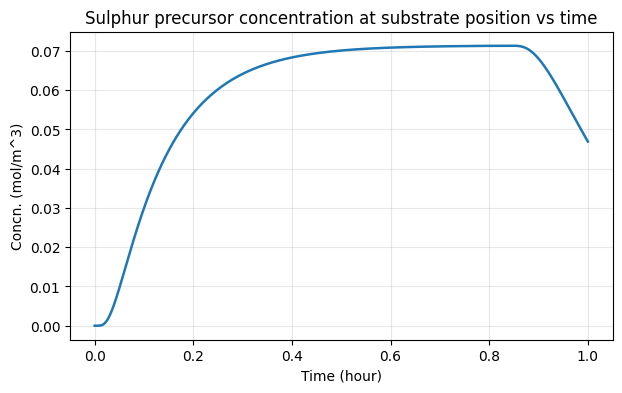

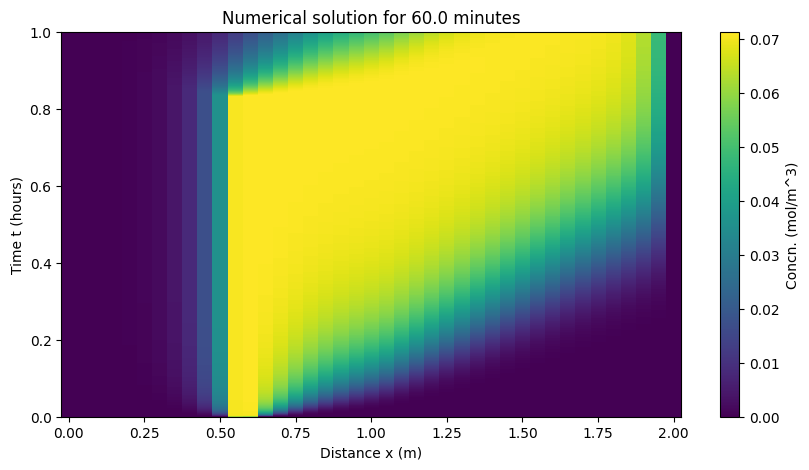

In [15]:

# ------------------ Main simulation ------------------
def run_simulation(flow_sccm: float,
                   tfinal_s: float,
                   tstep_s: float = 1.0,
                   make_plots: bool = True):
    """
    Parameters
    ----------
    flow_sccm : float
        N2 flow rate (sccm)
    tfinal_s : float
        Final time (s)
    tstep_s : float
        Output sampling step (s)
    make_plots : bool
        Whether to display plots

    Returns
    -------
    dict with x, t (s), U (concentration), and parameters.
    """
    # Derived quantities
    FRN2_mol_s = ((flow_sccm / 60.0) * 1e-6) * densityN2 / MMN2
    V = ((flow_sccm / 60.0) * 1e-6) / A

    # Profiles along x
    T_degC_x = temperature_profile_degC(x)
    D_x = compute_diffusivity(x)

    # Saturation pressure
    P = saturation_pressure_Pa(Tp)

    # Initial condition
    u0 = np.zeros(Nx, dtype=float)

    # Build RHS
    rhs = build_rhs(V=V, D=D_x, P=P)

    # Time sampling
    t_eval = np.arange(0.0, tfinal_s + tstep_s, tstep_s)

    # Solve
    sol = solve_ivp(
        fun=rhs,
        t_span=(0.0, tfinal_s),
        y0=u0,
        method="BDF",          # stiff solver suited to diffusion
        t_eval=t_eval,
        atol=1e-8,
        rtol=1e-6,
        max_step=max(1.0, tstep_s)
    )

    if not sol.success:
        raise RuntimeError(f"ODE solver failed: {sol.message}")

    T = sol.t
    U = sol.y.T  # (time, space)

    # ------------------ Plots ------------------
    if make_plots:
        # 1) Concentration at substrate vs time (hours)
        fig1, ax1 = plt.subplots(figsize=(7, 4))
        ax1.plot(T / 3600.0, U[:, substrate_idx], lw=1.8)
        ax1.set_title("Sulphur precursor concentration at substrate position vs time")
        ax1.set_xlabel("Time (hour)")
        ax1.set_ylabel("Concn. (mol/m^3)")
        ax1.grid(True, alpha=0.3)
        plt.show()

        # 2) Space–time surface (pcolormesh)
        Xmesh, Tmesh = np.meshgrid(x, T)
        fig2, ax2 = plt.subplots(figsize=(10, 5))
        pcm = ax2.pcolormesh(Xmesh, Tmesh / 3600.0, U, cmap='viridis', shading='auto')
        ax2.set_title(f"Numerical solution for {tfinal_s/60:.1f} minutes")
        ax2.set_xlabel("Distance x (m)")
        ax2.set_ylabel("Time t (hours)")
        cbar = fig2.colorbar(pcm, ax=ax2)
        cbar.set_label("Concn. (mol/m^3)")
        plt.show()

    return {
        "x": x,
        "t_s": T,
        "U": U,
        "flow_sccm": flow_sccm,
        "FRN2_mol_s": FRN2_mol_s,
        "V_m_s": V,
        "Temp_degC_x": T_degC_x,
        "D_m2_s_x": D_x,
        "P_Pa": P
    }


if __name__ == "__main__":
    # Interactive inputs (mirrors MATLAB prompts)
    try:
        flow_sccm = float(input("Flow rate in sccm:?  ").strip())
    except Exception:
        flow_sccm = 100.0
        print("Invalid input; using default flow_sccm=100")

    try:
        tfinal_s = float(input("Time for which solution is to be computed (in s)?  ").strip())
    except Exception:
        tfinal_s = 3000.0
        print("Invalid input; using default tfinal_s=3000")

    run_simulation(flow_sccm=flow_sccm, tfinal_s=tfinal_s, tstep_s=1.0, make_plots=True)